In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

### Get Block Group Geometries

In [2]:
import os
os.getcwd()

'/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot'

In [3]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/tl_2019_04_bg')

In [4]:
az_bg = gpd.read_file('tl_2019_04_bg.shp')

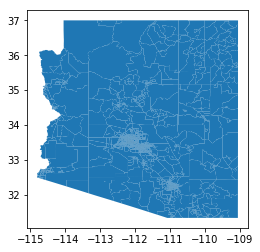

In [5]:
az_bg.plot()

In [6]:
az_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,013,421702,3,040134217023,Block Group 3,G5030,S,310375,0,+33.4123043,-111.7788867,"POLYGON ((-111.78406 33.41540, -111.78259 33.4..."
1,04,013,040531,2,040130405312,Block Group 2,G5030,S,616061,0,+33.6422660,-112.3722104,"POLYGON ((-112.37679 33.64389, -112.37673 33.6..."
2,04,013,092312,1,040130923121,Block Group 1,G5030,S,295623,0,+33.5654583,-112.1989360,"POLYGON ((-112.20294 33.56672, -112.20293 33.5..."
3,04,019,001000,1,040190010001,Block Group 1,G5030,S,680076,0,+32.2162888,-110.9777138,"POLYGON ((-110.98302 32.21429, -110.98248 32.2..."
4,04,019,001000,2,040190010002,Block Group 2,G5030,S,436369,0,+32.2076281,-110.9763828,"POLYGON ((-110.97941 32.21290, -110.97941 32.2..."


In [7]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/')

pkl_in_temp = open('tempems_pkl_021120', 'rb')

df = pickle.load(pkl_in_temp)

key = df.filter(['tract'])
key.drop_duplicates(inplace=True)

In [8]:
key.tract = key.tract *100

In [9]:
key.tract.head()

0     318400.0
30    318501.0
33    318700.0
61    318800.0
82    318900.0
Name: tract, dtype: float64

In [10]:
az_bg.TRACTCE = az_bg.TRACTCE.astype(float) 

In [11]:
tempe_bg = az_bg.merge(key, left_on='TRACTCE', right_on='tract')

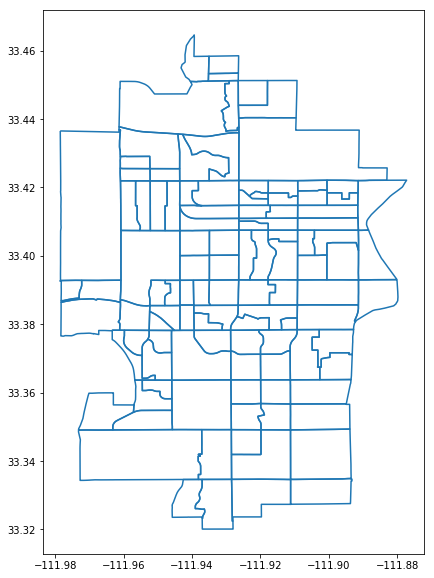

In [12]:
tempe_bg.boundary.plot(figsize=(10,10))

In [13]:
tempe_bg.GEOID.head()

0    040133191042
1    040133191043
2    040133191044
3    040133191041
4    040133197062
Name: GEOID, dtype: object

### Query Block Group PDB Data From Census 

In [14]:
year='2019'
dsource='pdb/blockgroup'
cols='State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17'
state='04'
county='013'
api_key='b76534619ffbdeef7355569c1b9cafd6a55fce2b'

In [15]:
base_url = f'https://api.census.gov/data/{year}/{dsource}'

In [16]:
data_url = f'{base_url}?get={cols}&for=block%20group:*&in=state:{state}&in=county:{county}&in=tract:*&key={api_key}'

In [17]:
response=requests.get(data_url)

In [18]:
data=response.json()
pdb_bg=pd.DataFrame(data[1:], columns=data[0])

In [19]:
pdb_bg.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,state,county,tract,block group
0,Arizona,Maricopa County,040130101011,1818,49.23,8.36,17.38,47.63,9.74,0.88,...,0,1.05,"$98,056",5.17,"$600,000",56.51,04,013,010101,1
1,Arizona,Maricopa County,040130101012,1758,48.75,0,10.3,25.03,45.79,3.53,...,0,0,"$86,518",3.7,"$538,700",56.24,04,013,010101,2
2,Arizona,Maricopa County,040130101013,1339,49.81,0,0,17.92,82.08,0,...,0,0,"$83,897",2.09,"$479,700",56.83,04,013,010101,3
3,Arizona,Maricopa County,040130101021,978,53.89,0.2,23.31,45.5,28.02,4.29,...,2.56,0,"$104,809",4.15,"$476,100",24.6,04,013,010102,1
4,Arizona,Maricopa County,040130101022,1439,53.79,1.25,2.85,42.88,50.8,0,...,0,8.13,"$95,154",17.44,"$724,300",61.2,04,013,010102,2


In [20]:
tempe = pdb_bg.merge(tempe_bg, left_on='GIDBG', right_on='GEOID')

In [21]:
tempe.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tract_y
0,Arizona,Maricopa County,040133184003,1021,52.5,7.84,42.41,25.66,6.86,54.46,...,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,"POLYGON ((-111.92643 33.44398, -111.92636 33.4...",318400.0
1,Arizona,Maricopa County,040133184001,2307,52.19,15.08,46.29,8.15,6.98,55.57,...,040133184001,Block Group 1,G5030,S,635617,0,+33.4476431,-111.9221824,"POLYGON ((-111.92646 33.45125, -111.92548 33.4...",318400.0
2,Arizona,Maricopa County,040133184002,1808,58.9,26.83,40.04,22.79,1.22,28.98,...,040133184002,Block Group 2,G5030,S,6105549,156123,+33.4311846,-111.9069608,"POLYGON ((-111.92633 33.44029, -111.92580 33.4...",318400.0
3,Arizona,Maricopa County,040133185011,1909,40.18,9.8,29.7,27.55,16.03,27.76,...,040133185011,Block Group 1,G5030,S,455164,0,+33.4558912,-111.9307318,"POLYGON ((-111.93513 33.45398, -111.93511 33.4...",318501.0
4,Arizona,Maricopa County,040133187002,1316,70.06,70.14,20.21,3.95,1.29,10.49,...,040133187002,Block Group 2,G5030,S,1160117,0,+33.4269986,-111.9378194,"POLYGON ((-111.94419 33.43565, -111.94409 33.4...",318700.0


### Import and Merge with Tempe EMS calls

In [22]:
#tempe ems 
eurl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Opioid_Calls/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
tempems = gpd.read_file(eurl)

In [23]:
tempems = tempems[tempems['Opioid_Use'] == 'Yes']
tempems.shape

(745, 20)

In [24]:
tempems.head()

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,Patient_Gender,Patient_ASU,Patient_Veteran,Patient_Homeless,Latitude_Random,Longitude_Random,Spec_Pop,Notes,Time_of_Day,geometry
0,1,1483401600000,Tuesday,(3) Tuesday,January,(01) January,2017,Yes,NULL,40 to 44,Female,No,No,No,33.4196,-111.8904,None,None,Morning,POINT (-111.89040 33.41960)
2,3,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.3971,-111.9249,Homeless,None,Overnight,POINT (-111.92490 33.39710)
3,4,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.4297,-111.9334,Homeless,None,Morning,POINT (-111.93340 33.42970)
4,5,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,70 to 74,Male,No,No,No,33.3681,-111.9014,None,None,Afternoon,POINT (-111.90140 33.36810)
6,7,1484179200000,Thursday,(5) Thursday,January,(01) January,2017,Yes,NULL,50 to 54,Female,No,No,No,33.4647,-111.9212,None,None,Evening,POINT (-111.92120 33.46470)


In [25]:
tempe = gpd.GeoDataFrame(tempe, geometry=tempe.geometry)

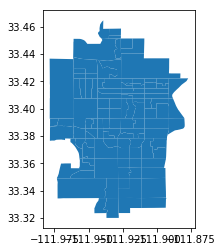

In [26]:
tempe.plot()

In [27]:
tempe_tract = pd.DataFrame()
for i in range(len(tempe)):
    df = tempems[tempems.within(tempe.loc[i,'geometry'])]
    df['GIDBG'] = tempe.loc[i,'GIDBG']
    tempe_tract = pd.concat([tempe_tract, df], axis=0)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
tempe_tract.columns

Index(['OBJECTID', 'Incident_Date', 'Weekday', 'Weekday_Sort', 'Month',
       'Month_Sort', 'Year', 'Opioid_Use', 'Narcan_Given', 'Age',
       'Patient_Gender', 'Patient_ASU', 'Patient_Veteran', 'Patient_Homeless',
       'Latitude_Random', 'Longitude_Random', 'Spec_Pop', 'Notes',
       'Time_of_Day', 'geometry', 'GIDBG'],
      dtype='object')

In [29]:
tempems.shape

(745, 20)

In [30]:
tempe_tract.shape

(675, 21)

In [31]:
tempe_tract = tempe_tract.merge(tempe, on='GIDBG')

In [32]:
tempe_tract.shape

(675, 55)

In [33]:
tempe_tract.columns

Index(['OBJECTID', 'Incident_Date', 'Weekday', 'Weekday_Sort', 'Month',
       'Month_Sort', 'Year', 'Opioid_Use', 'Narcan_Given', 'Age',
       'Patient_Gender', 'Patient_ASU', 'Patient_Veteran', 'Patient_Homeless',
       'Latitude_Random', 'Longitude_Random', 'Spec_Pop', 'Notes',
       'Time_of_Day', 'geometry_x', 'GIDBG', 'State_name', 'County_name',
       'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17', 'state',
       'county', 'tract_x', 'block group', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON',

In [34]:
tempe_tract.drop('geometry_y', inplace=True, axis=1)

In [35]:
tempe_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
tempe_tract = gpd.GeoDataFrame(tempe_tract, geometry=tempe_tract.geometry)

In [36]:
tempe_tract.shape

(675, 54)

In [37]:
tempe_tract.head()

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,...,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,tract_y
0,73,1489190400000,Saturday,(7) Saturday,March,(03) March,2017,Yes,NULL,25 to 29,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,318400.0
1,82,1490140800000,Wednesday,(4) Wednesday,March,(03) March,2017,Yes,NULL,25 to 29,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,318400.0
2,165,1495065600000,Thursday,(5) Thursday,May,(05) May,2017,Yes,Yes,30 to 34,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,318400.0
3,227,1499212800000,Wednesday,(4) Wednesday,July,(07) July,2017,Yes,Yes,50 to 54,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,318400.0
4,257,1500940800000,Tuesday,(3) Tuesday,July,(07) July,2017,Yes,Yes,20 to 24,...,3,040133184003,Block Group 3,G5030,S,1264540,9466,+33.4456486,-111.9158486,318400.0


In [38]:
tempe_tract.columns

Index(['OBJECTID', 'Incident_Date', 'Weekday', 'Weekday_Sort', 'Month',
       'Month_Sort', 'Year', 'Opioid_Use', 'Narcan_Given', 'Age',
       'Patient_Gender', 'Patient_ASU', 'Patient_Veteran', 'Patient_Homeless',
       'Latitude_Random', 'Longitude_Random', 'Spec_Pop', 'Notes',
       'Time_of_Day', 'geometry', 'GIDBG', 'State_name', 'County_name',
       'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17', 'state',
       'county', 'tract_x', 'block group', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', '

In [39]:
from time import strptime
for i in range(len(tempe_tract)):
    tempe_tract['Month'][i] = strptime(tempe_tract['Month'][i], '%B').tm_mon
    

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
tempe_tract['year_month']= tempe_tract['Year'] + tempe_tract['Month']/100

In [41]:
op = tempe_tract.filter(['GIDBG', 'year_month', 'Opioid_Use'])

In [42]:
op.head()

,GIDBG,year_month,Opioid_Use
0,040133184003,2017.03,Yes
1,040133184003,2017.03,Yes
2,040133184003,2017.05,Yes
3,040133184003,2017.07,Yes
4,040133184003,2017.07,Yes


In [43]:
op = op.groupby(by=[op['GIDBG'], op['year_month']]).count()

In [44]:
op.reset_index(inplace=True)

In [45]:
var = ['geometry', 'GIDBG', 'Tot_Population_ACS_13_17','pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17','Med_HHD_Inc_BG_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','Med_House_Value_BG_ACS_13_17','pct_College_ACS_13_17',
       'year_month']

In [46]:
tempe_tract = tempe_tract.filter(var)

In [47]:
tempe_tract.dtypes

geometry                         geometry
GIDBG                              object
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
year_month                         object
dtype: object

In [48]:
tempe_tract['Med_HHD_Inc_BG_ACS_13_17'] = tempe_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace('$', '')
tempe_tract['Med_HHD_Inc_BG_ACS_13_17'] = tempe_tract['Med_HHD_Inc_BG_ACS_13_17'].str.replace(',', '')
tempe_tract['Med_House_Value_BG_ACS_13_17'] = tempe_tract['Med_House_Value_BG_ACS_13_17'].str.replace('$', '')
tempe_tract['Med_House_Value_BG_ACS_13_17'] = tempe_tract['Med_House_Value_BG_ACS_13_17'].str.replace(',', '')


In [49]:
for i in range(1,len(tempe_tract.columns)):
    tempe_tract[tempe_tract.columns[i]] = tempe_tract[tempe_tract.columns[i]].astype(float)

In [50]:
tempe_tract.dtypes

geometry                         geometry
GIDBG                             float64
Tot_Population_ACS_13_17          float64
pct_Males_ACS_13_17               float64
pct_Pop_18_24_ACS_13_17           float64
pct_Pop_25_44_ACS_13_17           float64
pct_Pop_45_64_ACS_13_17           float64
pct_Pop_65plus_ACS_13_17          float64
pct_Hispanic_ACS_13_17            float64
pct_NH_White_alone_CEN_2010       float64
pct_NH_Blk_alone_ACS_13_17        float64
pct_NH_Asian_alone_ACS_13_17      float64
Med_HHD_Inc_BG_ACS_13_17          float64
pct_Prs_Blw_Pov_Lev_ACS_13_17     float64
Med_House_Value_BG_ACS_13_17      float64
pct_College_ACS_13_17             float64
year_month                        float64
dtype: object

In [51]:
tempe_tract = tempe_tract.groupby(by=[tempe_tract['GIDBG'], tempe_tract['year_month']]).mean()

In [52]:
tempe_tract.drop(columns='year_month', inplace=True)

In [53]:
tempe_tract.columns

Index(['GIDBG', 'Tot_Population_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17',
       'pct_Pop_45_64_ACS_13_17', 'pct_Pop_65plus_ACS_13_17',
       'pct_Hispanic_ACS_13_17', 'pct_NH_White_alone_CEN_2010',
       'pct_NH_Blk_alone_ACS_13_17', 'pct_NH_Asian_alone_ACS_13_17',
       'Med_HHD_Inc_BG_ACS_13_17', 'pct_Prs_Blw_Pov_Lev_ACS_13_17',
       'Med_House_Value_BG_ACS_13_17', 'pct_College_ACS_13_17'],
      dtype='object')

In [54]:
tempe_tract.head()

GIDBG  Tot_Population_ACS_13_17  \
GIDBG        year_month                                           
4.013318e+10 2017.01     4.013318e+10                    2307.0   
             2017.03     4.013318e+10                    2307.0   
             2017.07     4.013318e+10                    2307.0   
             2017.09     4.013318e+10                    2307.0   
             2017.11     4.013318e+10                    2307.0   

                         pct_Males_ACS_13_17  pct_Pop_18_24_ACS_13_17  \
GIDBG        year_month                                                 
4.013318e+10 2017.01                   52.19                    15.08   
             2017.03                   52.19                    15.08   
             2017.07                   52.19                    15.08   
             2017.09                   52.19                    15.08   
             2017.11                   52.19                    15.08   

                         pct_Pop_25_44_ACS_13_17  pct_Pop_45_64_ACS_13_17  \
GIDBG        year_month                                                     
4.013318e+10 2017.01                       46.29                     8.15   
             2017.03                       46.29                     8.15   
             2017.07                       46.29                     8.15   
             2017.09                       46.29                     8.15   
             2017.11                       46.29                     8.15   

                         pct_Pop_65plus_ACS_13_17  pct_Hispanic_ACS_13_17  \
GIDBG        year_month                                                     
4.013318e+10 2017.01                         6.98                   55.57   
             2017.03                         6.98                   55.57   
             2017.07                         6.98                   55.57   
             2017.09                         6.98                   55.57   
             2017.11                         6.98                   55.57   

                         pct_NH_White_alone_CEN_2010  \
GIDBG        year_month                                
4.013318e+10 2017.01                           68.51   
             2017.03                           68.51   
             2017.07                           68.51   
             2017.09                           68.51   
             2017.11                           68.51   

                         pct_NH_Blk_alone_ACS_13_17  \
GIDBG        year_month                               
4.013318e+10 2017.01                           0.56   
             2017.03                           0.56   
             2017.07                           0.56   
             2017.09                           0.56   
             2017.11                           0.56   

                         pct_NH_Asian_alone_ACS_13_17  \
GIDBG        year_month                                 
4.013318e+10 2017.01                             4.33   
             2017.03                             4.33   
             2017.07                             4.33   
             2017.09                             4.33   
             2017.11                             4.33   

                         Med_HHD_Inc_BG_ACS_13_17  \
GIDBG        year_month                             
4.013318e+10 2017.01                      51155.0   
             2017.03                      51155.0   
             2017.07                      51155.0   
             2017.09                      51155.0   
             2017.11                      51155.0   

                         pct_Prs_Blw_Pov_Lev_ACS_13_17  \
GIDBG        year_month                                  
4.013318e+10 2017.01                             27.52   
             2017.03                             27.52   
             2017.07                             27.52   
             2017.09                             27.52   
             2017.11                             27.52   

            

In [56]:
tempe_tract.drop(columns=['GIDBG'], inplace=True)

In [57]:
tempe_tract.reset_index(inplace=True)

In [58]:
tempe_tract.head()

,GIDBG,year_month,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17
0,4.013318e+10,2017.01,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69
1,4.013318e+10,2017.03,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69
2,4.013318e+10,2017.07,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69
3,4.013318e+10,2017.09,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69
4,4.013318e+10,2017.11,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69


In [59]:
op.dtypes

GIDBG          object
year_month    float64
Opioid_Use      int64
dtype: object

In [60]:
op.GIDBG = op.GIDBG.astype(float)

In [61]:
df = tempe_tract.merge(op, on=['GIDBG', 'year_month'])

In [62]:
df.shape

(534, 17)

In [63]:
sum(df.Opioid_Use)

675

In [64]:
df.rename(columns={'Opioid_Use':'ems_calls'}, inplace=True)

In [65]:
df.head()

,GIDBG,year_month,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,ems_calls
0,4.013318e+10,2017.01,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
1,4.013318e+10,2017.03,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,3
2,4.013318e+10,2017.07,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
3,4.013318e+10,2017.09,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
4,4.013318e+10,2017.11,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1


In [66]:
pickle_out = open("tempems_bg_pkl_022020","wb")
pickle.dump(df, pickle_out)
pickle_out.close()

### Get Descriptive Statistics

In [86]:
bg_pkl = open('tempems_bg_pkl_022020', 'rb')

df = pickle.load(bg_pkl)

In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GIDBG,534.0,4.013321e+10,300110.843636,4.013318e+10,4.013319e+10,4.013319e+10,4.013320e+10,4.013810e+10
year_month,534.0,2.017881e+03,0.791276,2.017010e+03,2.017070e+03,2.018030e+03,2.018120e+03,2.019080e+03
Tot_Population_ACS_13_17,534.0,1.695079e+03,646.812938,4.230000e+02,1.230250e+03,1.777000e+03,2.079000e+03,4.477000e+03
pct_Males_ACS_13_17,534.0,5.480345e+01,8.190265,2.757000e+01,4.935000e+01,5.546000e+01,6.054250e+01,7.473000e+01
pct_Pop_18_24_ACS_13_17,534.0,2.810507e+01,21.813523,0.000000e+00,1.481500e+01,2.289000e+01,3.405000e+01,9.491000e+01
pct_Pop_25_44_ACS_13_17,534.0,3.088386e+01,10.842533,3.950000e+00,2.404000e+01,2.970000e+01,3.957000e+01,5.914000e+01
pct_Pop_45_64_ACS_13_17,534.0,1.783614e+01,8.644418,0.000000e+00,1.119000e+01,1.876000e+01,2.279000e+01,4.287000e+01
pct_Pop_65plus_ACS_13_17,534.0,8.969551e+00,7.486050,0.000000e+00,3.550000e+00,6.970000e+00,1.230750e+01,4.154000e+01
pct_Hispanic_ACS_13_17,534.0,2.379639e+01,14.048954,0.000000e+00,1.287000e+01,2.221000e+01,3.277000e+01,8.418000e+01
pct_NH_White_alone_CEN_2010,534.0,6.074620e+01,14.182991,2.024000e+01,5.139000e+01,6.378000e+01,7.250000e+01,8.592000e+01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28926048>,
      dtype=object)

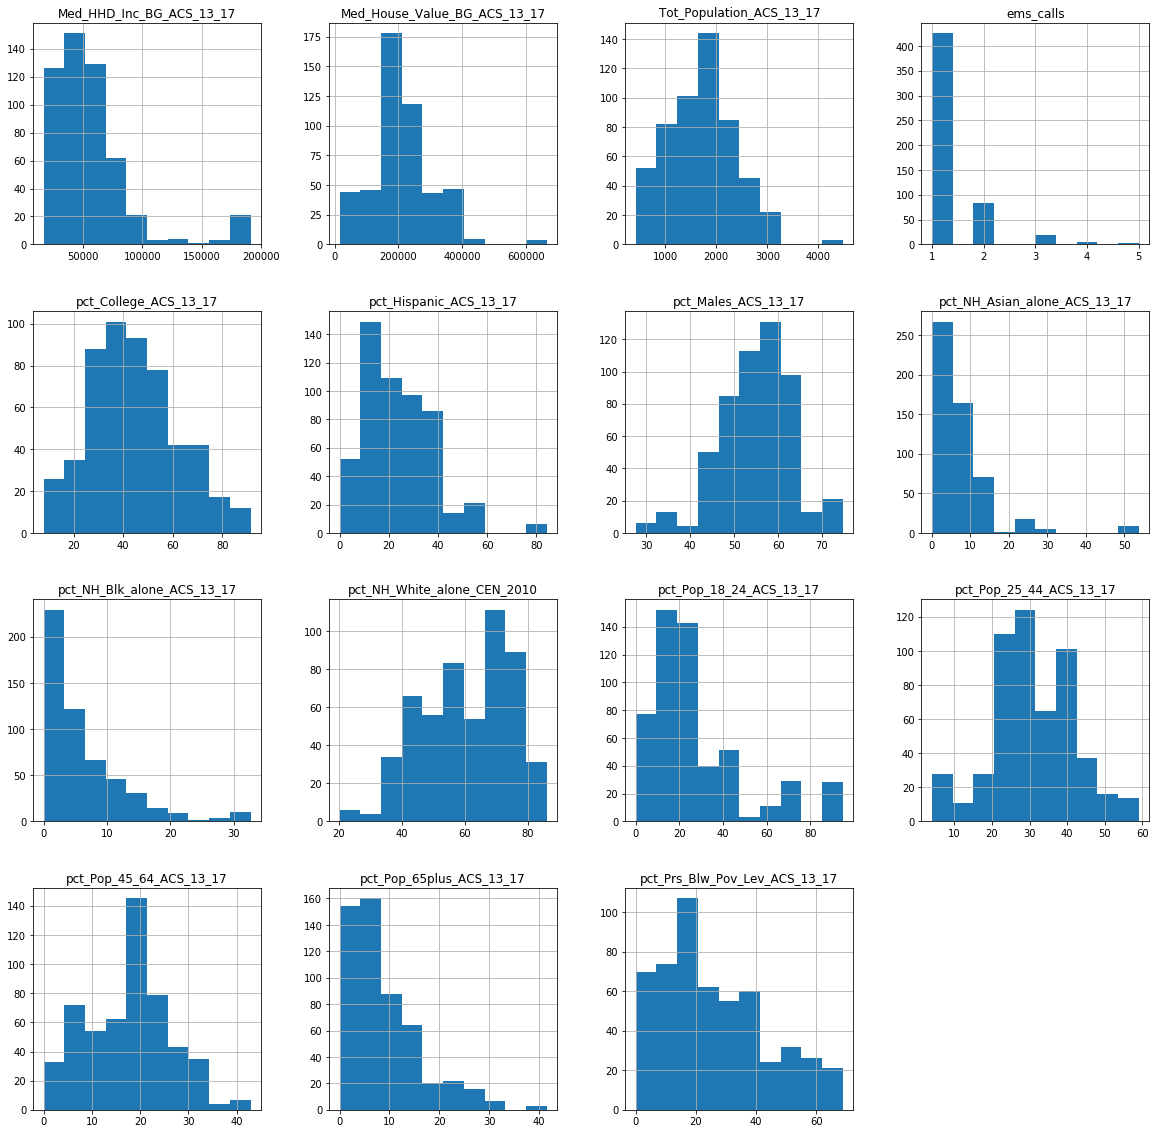

In [94]:
hist = df.drop(columns=['GIDBG', 'year_month'])
hist.hist(figsize=(20,20))

### Rapid Test Model

In [69]:
df.dropna(inplace=True)

In [70]:
df.head()

,GIDBG,year_month,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,ems_calls
0,4.013318e+10,2017.01,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
1,4.013318e+10,2017.03,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,3
2,4.013318e+10,2017.07,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
3,4.013318e+10,2017.09,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1
4,4.013318e+10,2017.11,2307.0,52.19,15.08,46.29,8.15,6.98,55.57,68.51,0.56,4.33,51155.0,27.52,155900.0,25.69,1


In [71]:
df.GIDBG = df.GIDBG.astype(object)

In [72]:
df.GIDBG.head()

0    4.01332e+10
1    4.01332e+10
2    4.01332e+10
3    4.01332e+10
4    4.01332e+10
Name: GIDBG, dtype: object

In [73]:
df.dtypes

GIDBG                             object
year_month                       float64
Tot_Population_ACS_13_17         float64
pct_Males_ACS_13_17              float64
pct_Pop_18_24_ACS_13_17          float64
pct_Pop_25_44_ACS_13_17          float64
pct_Pop_45_64_ACS_13_17          float64
pct_Pop_65plus_ACS_13_17         float64
pct_Hispanic_ACS_13_17           float64
pct_NH_White_alone_CEN_2010      float64
pct_NH_Blk_alone_ACS_13_17       float64
pct_NH_Asian_alone_ACS_13_17     float64
Med_HHD_Inc_BG_ACS_13_17         float64
pct_Prs_Blw_Pov_Lev_ACS_13_17    float64
Med_House_Value_BG_ACS_13_17     float64
pct_College_ACS_13_17            float64
ems_calls                          int64
dtype: object

In [74]:
df['log_pop'] = np.log(df.Tot_Population_ACS_13_17)

In [75]:
#put into $100,000
df.Med_HHD_Inc_BG_ACS_13_17 = df.Med_HHD_Inc_BG_ACS_13_17/100000

In [76]:
df.Med_House_Value_BG_ACS_13_17 = df.Med_House_Value_BG_ACS_13_17/1000000

In [77]:
df = pd.get_dummies(df, drop_first=True)

In [78]:
df.mean().T[0:14]

year_month                       2017.879979
Tot_Population_ACS_13_17         1705.056842
pct_Males_ACS_13_17                55.157221
pct_Pop_18_24_ACS_13_17            26.881495
pct_Pop_25_44_ACS_13_17            30.141179
pct_Pop_45_64_ACS_13_17            18.714337
pct_Pop_65plus_ACS_13_17            9.573305
pct_Hispanic_ACS_13_17             24.329979
pct_NH_White_alone_CEN_2010        61.877747
pct_NH_Blk_alone_ACS_13_17          5.689179
pct_NH_Asian_alone_ACS_13_17        6.528632
Med_HHD_Inc_BG_ACS_13_17            0.585800
pct_Prs_Blw_Pov_Lev_ACS_13_17      25.429516
Med_House_Value_BG_ACS_13_17        0.211747
dtype: float64

In [79]:
#scale percentage variables 
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    df[scl[i]] = df[scl[i]]/100

In [80]:
df.mean().T[:14]

year_month                       2017.879979
Tot_Population_ACS_13_17         1705.056842
pct_Males_ACS_13_17                 0.551572
pct_Pop_18_24_ACS_13_17             0.268815
pct_Pop_25_44_ACS_13_17             0.301412
pct_Pop_45_64_ACS_13_17             0.187143
pct_Pop_65plus_ACS_13_17            0.095733
pct_Hispanic_ACS_13_17              0.243300
pct_NH_White_alone_CEN_2010         0.618777
pct_NH_Blk_alone_ACS_13_17          0.056892
pct_NH_Asian_alone_ACS_13_17        0.065286
Med_HHD_Inc_BG_ACS_13_17            0.585800
pct_Prs_Blw_Pov_Lev_ACS_13_17       0.254295
Med_House_Value_BG_ACS_13_17        0.211747
dtype: float64

In [81]:
X, y = df, df.ems_calls
X.drop(columns=['ems_calls','year_month', 'Tot_Population_ACS_13_17'], inplace=True)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                  380
Model:                            GLM   Df Residuals:                      299
Model Family:                 Poisson   Df Model:                           80
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -434.46
Date:                Mon, 02 Mar 2020   Deviance:                       53.244
Time:                        22:44:34   Pearson chi2:                     59.8
No. Iterations:                   100   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.0611      0.323      0.189      0.850      -0.572       0

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(array([ 13.,   0.,  22.,  18.,  48.,  62.,  61., 154.,  64.,  33.]),
 array([6.04737218, 6.25009987, 6.45282756, 6.65555525, 6.85828294,
        7.06101063, 7.26373832, 7.46646601, 7.6691937 , 7.87192139,
        8.07464908]),
 <a list of 10 Patch objects>)

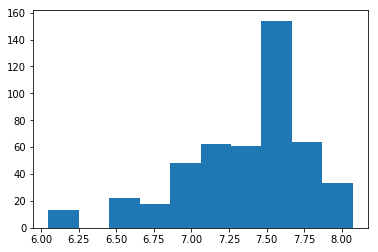